In [14]:
import cv2
import numpy as np

# Baca gambar daun (pastikan gambar sudah tersegmentasi)
image = cv2.imread("C:\\Users\\muham\\Downloads\\KULIAH\\Semester 5\\3. Mathematical Tools For Data Science\\Mango_Leaf_Disease\\Bacterial Canker\\IMG_20211106_141934 (Custom).jpg", cv2.IMREAD_GRAYSCALE)

# Temukan kontur daun
contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Pilih kontur daun terbesar (jika ada lebih dari satu)
largest_contour = max(contours, key=cv2.contourArea)

# Hitung momen pusat massa
M = cv2.moments(largest_contour)
center_x = int(M["m10"] / M["m00"])
center_y = int(M["m01"] / M["m00"])

# Hitung jarak dari pusat ke tepi dalam berbagai arah
distances = []
for point in largest_contour:
    x, y = point[0]
    distance = np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2)
    distances.append(distance)

# Hitung rata-rata jarak sebagai radius
radius = np.mean(distances)

print("Radius daun:", radius)

Radius daun: 199.3006522813257


In [1]:
import os
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from skimage.io import imread
from skimage.transform import resize
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Fungsi untuk mengambil daftar file gambar dari direktori
def get_image_files(directory):
    image_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith((".jpg", ".jpeg", ".png")):
                image_files.append(os.path.join(root, file))
    return image_files

In [3]:
# Fungsi untuk meng-load dan mengubah gambar menjadi data numerik
def load_and_preprocess_images(image_files, target_size=(100, 100)):  # Tambahkan parameter target_size
    images_data = []
    for img_file in image_files:
        img = imread(img_file)
        if img is not None:
            # Resize gambar menjadi ukuran tertentu jika diperlukan
            img = resize(img, target_size)  # Resize gambar ke ukuran target
            images_data.append(img.flatten())  # Flatten gambar ke dalam satu dimensi
    return np.array(images_data)

In [4]:
# Load dataset gambar dari direktori tertentu
image_directory = "C:\\Users\\muham\\Downloads\\KULIAH\\Semester 5\\3. Mathematical Tools For Data Science\Mango_Leaf_Disease"
image_files = get_image_files(image_directory)
image_data = load_and_preprocess_images(image_files)

In [5]:
# Mendapatkan jumlah kelas (class) dari dataset gambar
num_classes = len(os.listdir(image_directory))
print(num_classes)

8


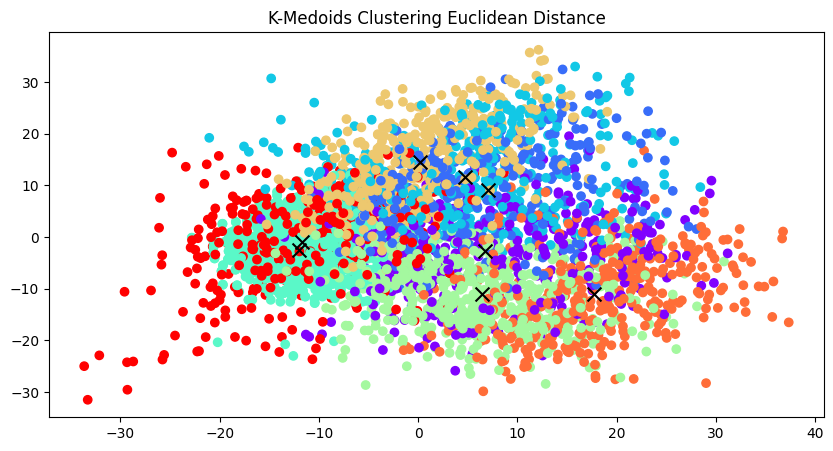

In [15]:
# K-Medoid Euclidean Distances
def initialize_medoids(data, k):
    medoids_idx = np.random.choice(len(data), k, replace=False)
    return data[medoids_idx]

# Code perhitungan jarak Euclidean
def compute_distances(data, medoids):
    distances = np.zeros((len(data), len(medoids)))
    for i, medoid in enumerate(medoids):
        distances[:, i] = np.linalg.norm(data - medoid, axis=1)
    return distances

def assign_clusters(distances):
    return np.argmin(distances, axis=1)

def total_cost(distances, assignments):
    return np.sum(distances[np.arange(len(distances)), assignments])

def k_medoids(data, k, max_iters=100):
    medoids = initialize_medoids(data, k)
    for _ in range(max_iters):
        distances = compute_distances(data, medoids)
        assignments = assign_clusters(distances)
        new_medoids = np.array([data[assignments == i].mean(axis=0) for i in range(k)])
        if np.all(new_medoids == medoids):
            break
        medoids = new_medoids
    return medoids, assignments

k = num_classes
medoids, assignments = k_medoids(image_data, k)

# Visualisasi
plt.figure(figsize=(10,5))
pca = PCA(n_components=2)
pca_result = pca.fit_transform(image_data)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=assignments, cmap='rainbow')
plt.scatter(pca.transform(medoids)[:, 0], pca.transform(medoids)[:, 1], marker='x', s=100, c='black')
plt.title('K-Medoids Clustering Euclidean Distance')
plt.show()

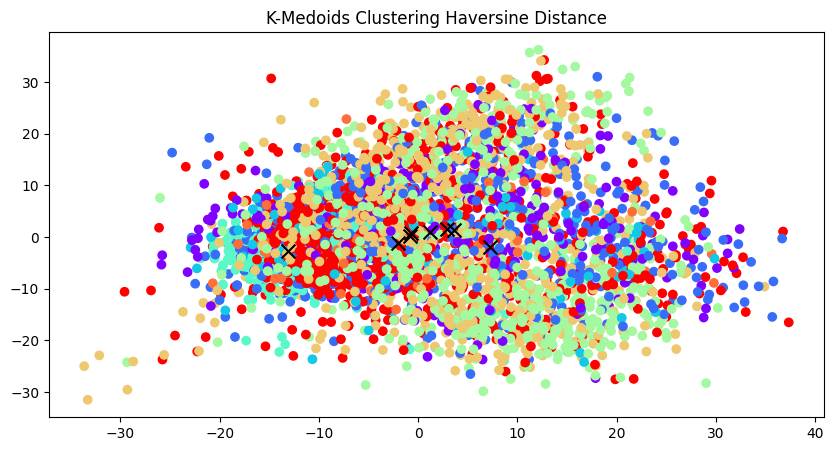

In [16]:
# Algoritma K-Medoids dengan Haversine distance
def haversine(lat1, lon1, lat2, lon2):
    R = 199.3006522813257

    # Konversi koordinat dari derajat ke radian
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = R * c

    return distance

def initialize_medoids(data, k):
    medoids_idx = np.random.choice(len(data), k, replace=False)
    return data[medoids_idx]

def compute_distances_haversine(data, medoids):
    distances = np.zeros((len(data), len(medoids)))
    for i, medoid in enumerate(medoids):
        for j, datapoint in enumerate(data):
            distances[j, i] = haversine(datapoint[0], datapoint[1], medoid[0], medoid[1])
    return distances

def assign_clusters(distances):
    return np.argmin(distances, axis=1)

def total_cost(distances, assignments):
    return np.sum(distances[np.arange(len(distances)), assignments])

def k_medoids_haversine(data, k, max_iters=100):
    medoids = initialize_medoids(data, k)
    for _ in range(max_iters):
        distances = compute_distances_haversine(data, medoids)
        assignments = assign_clusters(distances)
        new_medoids = np.array([data[assignments == i].mean(axis=0) for i in range(k)])
        if np.all(new_medoids == medoids):
            break
        medoids = new_medoids
    return medoids, assignments

# Contoh penggunaan algoritma K-Medoids dengan Haversine distance
k = num_classes
medoids, assignments = k_medoids_haversine(image_data, k)

# Visualisasi hasil clustering
plt.figure(figsize=(10, 5))
pca = PCA(n_components=2)
pca_result = pca.fit_transform(image_data)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=assignments, cmap='rainbow')
plt.scatter(pca.transform(medoids)[:, 0], pca.transform(medoids)[:, 1], marker='x', s=100, c='black')
plt.title('K-Medoids Clustering Haversine Distance')
plt.show()

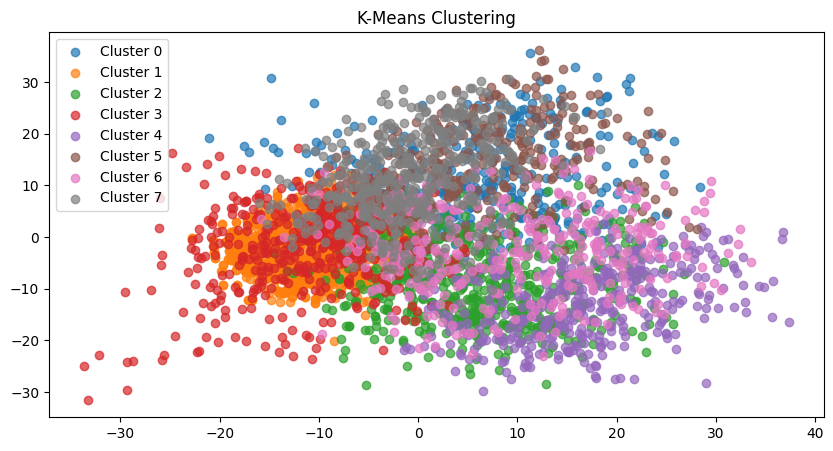

In [16]:
# Klastering dengan K-Means dengan jumlah kluster sesuai jumlah kelas
target_size = (100, 100)
kmeans = KMeans(n_clusters=num_classes, n_init=10)
kmeans_labels = kmeans.fit_predict(image_data)

# Reduksi dimensi dengan PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(image_data)

# Visualisasi hasil klastering dengan scatter plot
plt.figure(figsize=(10, 5))
for cluster in range(kmeans.n_clusters):
    cluster_data = reduced_data[kmeans_labels == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster}', alpha=0.7)

plt.legend()
plt.title('K-Means Clustering Euclidean Distance')
plt.show()

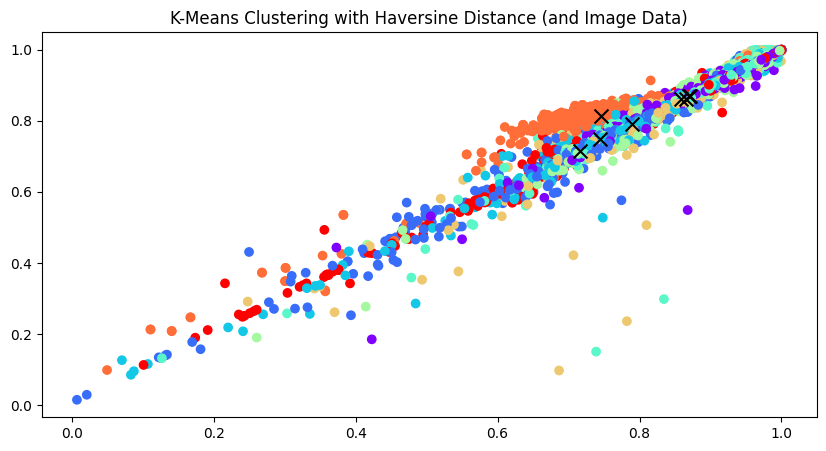

In [36]:
import os
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from scipy.spatial.distance import cdist

# Fungsi untuk menghitung Haversine distance antara dua titik dalam derajat
def haversine(lat1, lon1, lat2, lon2):
    # Radius Bumi dalam kilometer
    R = 199.3006522813257
    
    # Mengonversi koordinat lintang dan bujur dari derajat ke radian
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)
    
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    distance = R * c
    return distance

# Fungsi untuk mengambil daftar file gambar dari direktori
def get_image_files(directory):
    image_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith((".jpg", ".jpeg", ".png")):
                image_files.append(os.path.join(root, file))
    return image_files

# Fungsi untuk meng-load dan mengubah gambar menjadi data numerik
def load_and_preprocess_images(image_files, target_size=(100, 100), coordinates=None):
    images_data = []
    for img_file in image_files:
        img = imread(img_file)
        if img is not None:
            img = resize(img, target_size)
            if coordinates is not None:
                # Hitung jarak Haversine dari koordinat referensi
                lat1, lon1 = coordinates
                lat2, lon2 = np.random.uniform(-90, 90), np.random.uniform(-180, 180)
                distance = haversine(lat1, lon1, lat2, lon2)
                images_data.append(np.append(img.flatten(), distance))
            else:
                images_data.append(img.flatten())
    return np.array(images_data)

latitude1 = -6.123456  # Ganti dengan nilai koordinat lintang yang sesuai
longitude1 = 106.789012  # Ganti dengan nilai koordinat bujur yang sesuai

# Load dataset gambar dari direktori tertentu
image_directory = "C:\\Users\\muham\\Downloads\\KULIAH\\Semester 5\\3. Mathematical Tools For Data Science\\Mango_Leaf_Disease"
image_files = get_image_files(image_directory)

# Koordinat lintang dan bujur referensi (contoh data)
reference_coordinates = (latitude1, longitude1)

# Load dan preprocess gambar dengan menyertakan jarak Haversine
image_data = load_and_preprocess_images(image_files, target_size=(100, 100), coordinates=reference_coordinates)

# Mendapatkan jumlah kelas (class) dari dataset gambar
num_classes = len(os.listdir(image_directory))

# Klastering dengan K-Means dan Haversine Distance
num_clusters = num_classes  # Jumlah kluster yang sesuai dengan jumlah kelas
kmeans = KMeans(n_clusters=num_clusters, n_init=10)
kmeans_labels = kmeans.fit_predict(image_data[:, :-1])  # Exclude the last column (Haversine distance)

# Visualisasi hasil klastering dengan scatter plot
plt.figure(figsize=(10, 5))
plt.scatter(image_data[:, 0], image_data[:, 1], c=kmeans_labels, cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x', s=100, c='black')
plt.title('K-Means Clustering with Haversine Distance (and Image Data)')
plt.show()


In [44]:
import time
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn_extra.cluster import KMedoids

# Fungsi untuk menghitung Haversine distance antara dua titik dalam derajat
def haversine(lat1, lon1, lat2, lon2):
    # Radius Bumi dalam kilometer
    R = 199
    
    # Mengonversi koordinat lintang dan bujur dari derajat ke radian
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)
    
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    distance = R * c
    return distance

# Fungsi untuk mengukur runtime K-Medoids dengan Euclidean Distance
def kmedoids_euclidean(data, k):
    start_time = time.time()
    kmedoids = KMedoids(n_clusters=k, metric="euclidean", random_state=0)
    kmedoids.fit(data)
    end_time = time.time()
    return end_time - start_time

# Fungsi untuk mengukur runtime K-Medoids dengan Haversine Distance
def kmedoids_haversine(data, k):
    start_time = time.time()
    distances = cdist(data, data, lambda u, v: haversine(u[0], u[1], v[0], v[1]))
    kmedoids = KMedoids(n_clusters=k, random_state=0)
    kmedoids.fit(distances)
    end_time = time.time()
    return end_time - start_time

# Fungsi untuk mengukur runtime K-Means dengan Euclidean Distance
def kmeans_euclidean(data, k):
    start_time = time.time()
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)
    kmeans.fit(data)
    end_time = time.time()
    return end_time - start_time

# Fungsi untuk mengukur runtime K-Means dengan Haversine Distance
def kmeans_haversine(data, k):
    start_time = time.time()
    distances = cdist(data, data, lambda u, v: haversine(u[0], u[1], v[0], v[1]))
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)
    kmeans.fit(distances)
    end_time = time.time()
    return end_time - start_time

# Buat nilai acak untuk latitude dan longitude
np.random.seed(0)  # Untuk hasil yang dapat direproduksi, atur seed
latitudes = np.random.uniform(-90, 90, 8)  # Latitude dalam rentang -90 hingga 90
longitudes = np.random.uniform(-180, 180, 8)  # Longitude dalam rentang -180 hingga 180

# Buat array koordinat dari nilai-nilai yang dihasilkan
coordinates = np.column_stack((latitudes, longitudes))

# Ukuran kluster yang diinginkan
k = 8

# Ukur waktu runtime
runtime_kmedoids_euclidean = kmedoids_euclidean(coordinates, k)
runtime_kmedoids_haversine = kmedoids_haversine(coordinates, k)
runtime_kmeans_euclidean = kmeans_euclidean(coordinates, k)
runtime_kmeans_haversine = kmeans_haversine(coordinates, k)

print(f"Runtime K-Medoids (Euclidean): {runtime_kmedoids_euclidean} seconds")
print(f"Runtime K-Medoids (Haversine): {runtime_kmedoids_haversine} seconds")
print(f"Runtime K-Means (Euclidean): {runtime_kmeans_euclidean} seconds")
print(f"Runtime K-Means (Haversine): {runtime_kmeans_haversine} seconds")


Runtime K-Medoids (Euclidean): 0.0016791820526123047 seconds
Runtime K-Medoids (Haversine): 0.002141714096069336 seconds
Runtime K-Means (Euclidean): 0.04351544380187988 seconds
Runtime K-Means (Haversine): 0.030599117279052734 seconds


In [49]:
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids

# Fungsi untuk menghitung Haversine distance antara dua titik dalam derajat
def haversine(lat1, lon1, lat2, lon2):
    # Radius Bumi dalam kilometer
    R = 199
    
    # Mengonversi koordinat lintang dan bujur dari derajat ke radian
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)
    
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    distance = R * c
    return distance

# Fungsi untuk mengukur runtime K-Medoids dengan Euclidean Distance
def kmedoids_euclidean(data, k):
    start_time = time.time()
    kmedoids = KMedoids(n_clusters=k, metric="euclidean", random_state=0)
    kmedoids.fit(data)
    end_time = time.time()
    return end_time - start_time, kmedoids.labels_

# Fungsi untuk mengukur runtime K-Medoids dengan Haversine Distance
def kmedoids_haversine(data, k):
    start_time = time.time()
    distances = cdist(data, data, lambda u, v: haversine(u[0], u[1], v[0], v[1]))
    kmedoids = KMedoids(n_clusters=k, random_state=0)
    kmedoids.fit(distances)
    end_time = time.time()
    return end_time - start_time, kmedoids.labels_

# Fungsi untuk mengukur runtime K-Means dengan Euclidean Distance
def kmeans_euclidean(data, k):
    start_time = time.time()
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)
    kmeans.fit(data)
    end_time = time.time()
    return end_time - start_time, kmeans.labels_

# Fungsi untuk mengukur runtime K-Means dengan Haversine Distance
def kmeans_haversine(data, k):
    start_time = time.time()
    distances = cdist(data, data, lambda u, v: haversine(u[0], u[1], v[0], v[1]))
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)
    kmeans.fit(distances)
    end_time = time.time()
    return end_time - start_time, kmeans.labels_

# Generate random latitude and longitude coordinates for 8 data points
num_data_points = 8
latitudes = np.random.uniform(-90, 90, num_data_points)  # Latitude in the range -90 to 90
longitudes = np.random.uniform(-180, 180, num_data_points)  # Longitude in the range -180 to 180

# Create an array of coordinates
coordinates = np.column_stack((latitudes, longitudes))

# Number of clusters (you can change this to your desired number)
num_clusters = 3

# Calculate runtime and labels for different clustering methods
runtime_kmedoids_euclidean, labels_kmedoids_euclidean = kmedoids_euclidean(coordinates, num_clusters)
runtime_kmedoids_haversine, labels_kmedoids_haversine = kmedoids_haversine(coordinates, num_clusters)
runtime_kmeans_euclidean, labels_kmeans_euclidean = kmeans_euclidean(coordinates, num_clusters)
runtime_kmeans_haversine, labels_kmeans_haversine = kmeans_haversine(coordinates, num_clusters)

# Evaluate clustering results using silhouette_score, davies_bouldin_score, and calinski_harabasz_score
silhouette_kmedoids_euclidean = silhouette_score(coordinates, labels_kmedoids_euclidean)
silhouette_kmedoids_haversine = silhouette_score(coordinates, labels_kmedoids_haversine)
silhouette_kmeans_euclidean = silhouette_score(coordinates, labels_kmeans_euclidean)
silhouette_kmeans_haversine = silhouette_score(coordinates, labels_kmeans_haversine)

davies_bouldin_kmedoids_euclidean = davies_bouldin_score(coordinates, labels_kmedoids_euclidean)
davies_bouldin_kmedoids_haversine = davies_bouldin_score(coordinates, labels_kmedoids_haversine)
davies_bouldin_kmeans_euclidean = davies_bouldin_score(coordinates, labels_kmeans_euclidean)
davies_bouldin_kmeans_haversine = davies_bouldin_score(coordinates, labels_kmeans_haversine)

calinski_harabasz_kmedoids_euclidean = calinski_harabasz_score(coordinates, labels_kmedoids_euclidean)
calinski_harabasz_kmedoids_haversine = calinski_harabasz_score(coordinates, labels_kmedoids_haversine)
calinski_harabasz_kmeans_euclidean = calinski_harabasz_score(coordinates, labels_kmeans_euclidean)
calinski_harabasz_kmeans_haversine = calinski_harabasz_score(coordinates, labels_kmeans_haversine)

# Display results in a table using Pandas
result_df = pd.DataFrame({
    "Method": ["K-Medoids (Euclidean)", "K-Medoids (Haversine)", "K-Means (Euclidean)", "K-Means (Haversine)"],
    "Silhouette Score": [silhouette_kmedoids_euclidean, silhouette_kmedoids_haversine, silhouette_kmeans_euclidean, silhouette_kmeans_haversine],
    "Davies-Bouldin Score": [davies_bouldin_kmedoids_euclidean, davies_bouldin_kmedoids_haversine, davies_bouldin_kmeans_euclidean, davies_bouldin_kmeans_haversine],
    "Calinski-Harabasz Score": [calinski_harabasz_kmedoids_euclidean, calinski_harabasz_kmedoids_haversine, calinski_harabasz_kmeans_euclidean, calinski_harabasz_kmeans_haversine]
})

print(result_df)

                  Method  Silhouette Score  Davies-Bouldin Score  \
0  K-Medoids (Euclidean)          0.496484              0.577281   
1  K-Medoids (Haversine)          0.473284              0.765156   
2    K-Means (Euclidean)          0.496484              0.577281   
3    K-Means (Haversine)          0.473284              0.765156   

   Calinski-Harabasz Score  
0                13.504927  
1                 8.546707  
2                13.504927  
3                 8.546707  
